In [1]:
import numpy as np
import pandas as pd
import os

import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms

from mpl_toolkits.mplot3d import Axes3D  
import mpl_toolkits.mplot3d as plt3d
import matplotlib.animation as animation

import matplotlib.pyplot as plt
from time import sleep

In [21]:
from torch import optim
import time
import math

In [2]:
data_path = "nturgb+d_skeletons/"
#### список отсутсвующих элементов так же будет доступен 
broken_files_path = "NTU_RGBD_samples_with_missing_skeletons.txt"

frame = 45

In [3]:
class Create_dataset():
    def read_data(self, data_path, broken_files_path):
        labels = []
        files = []
        action_classes = {}
        counter = 0
        files_counter = {}

        with open(broken_files_path, 'r') as f:
            broken_files = f.read().split("\n")

        raw_files = os.listdir(data_path)
        num_frames = 0

        for filename in raw_files:
            if filename not in broken_files:
                action_class = int(filename[filename.find('A') + 1:filename.find('A') + 4])
                subject_id = int(filename[filename.find('P') + 1:filename.find('P') + 4])
                camera_id = int(filename[filename.find('C') + 1:filename.find('C') + 4])
                if action_class in self.training_classes and camera_id in self.training_cameras:  #and subject_id in training_subjects:
                    if action_class in action_classes:
                        if files_counter[action_class] < 120:
                            files.append([filename,action_classes[action_class]])
                            files_counter[action_class] = files_counter[action_class] + 1
                    else:
                        action_classes.update({action_class : counter})
                        files_counter.update({action_class : 1})
                        counter+=1
                        files.append([filename,action_classes[action_class]])
    #                     labels.append([action_class])
        print("action classes: ", action_classes)
        print("action files: ", files_counter)

        return files, action_classes

    def get_nonzero_std(s): 
        index = s.sum(-1).sum(-1) != 0  
        s = s[index]
        if len(s) != 0:
            s = s[:, :, 0].std() + s[:, :, 1].std() + s[:, :, 2].std()  
        else:
            s = 0
        return s

    def read_skeleton_filter(self, file):
        with open(file, 'r') as f:
            skeleton_sequence = {}
            skeleton_sequence['numFrame'] = int(f.readline())
            skeleton_sequence['frameInfo'] = []
            for t in range(skeleton_sequence['numFrame']):
                frame_info = {}
                frame_info['numBody'] = int(f.readline())
                frame_info['bodyInfo'] = []

                for m in range(frame_info['numBody']):
                    body_info = {}
                    body_info_key = [
                        'bodyID', 'clipedEdges', 'handLeftConfidence',
                        'handLeftState', 'handRightConfidence', 'handRightState',
                        'isResticted', 'leanX', 'leanY', 'trackingState'
                    ]
                    body_info = {
                        k: float(v)
                        for k, v in zip(body_info_key, f.readline().split())
                    }
                    body_info['numJoint'] = int(f.readline())
                    body_info['jointInfo'] = []
                    for v in range(body_info['numJoint']):
                        joint_info_key = [
                            'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                            'orientationW', 'orientationX', 'orientationY',
                            'orientationZ', 'trackingState'
                        ]
                        joint_info = {
                            k: float(v)
                            for k, v in zip(joint_info_key, f.readline().split())
                        }
                        body_info['jointInfo'].append(joint_info)
                    frame_info['bodyInfo'].append(body_info)
                skeleton_sequence['frameInfo'].append(frame_info)

        return skeleton_sequence

    def read_xyz(self, file, max_body=1, num_joint=25):
        seq_info = self.read_skeleton_filter(file)
        data = np.zeros((max_body, seq_info['numFrame'], num_joint, 3))
        for n, f in enumerate(seq_info['frameInfo']):
            for m, b in enumerate(f['bodyInfo']):
                for j, v in enumerate(b['jointInfo']):
                    if m < max_body and j < num_joint:
                        data[m, n, j, :] = [v['x'], v['y'], v['z']]

                    else:
                        pass

        return data

    def create_coords_blocks(self, test_file, chonk_len = 45):   
        frame_counter = 0
        new_labels = []
        new_frames = []
        blocks = []

        test_frames = self.read_xyz(data_path + test_file[0])[0]
        label = test_file[1]
        slice_len = chonk_len * int(len(test_frames)/chonk_len)


        for index in range(len(test_frames[:slice_len])):
            frame_counter += 1
            new_frames.append(test_frames[index].flatten())
            if frame_counter == chonk_len:
                frame_counter = 0
                blocks.append(np.array(new_frames))
                new_labels = new_labels + [label]
                new_frames = []


        return blocks, new_labels
    
    def generate(self, frame):
        joints_framework = ['neck', 'nose', 'mid_hip',
                         'l_sho', 'l_elb',
                         'l_wri', 'l_hip',
                         'l_knee', 'l_ank',
                         'r_sho', 'r_elb',
                         'r_wri', 'r_hip',
                         'r_kne', 'r_ank',
                         'r_eye', 'l_eye',
                         'r_ear', 'l_ear']

        joints_framework_in_work = ['nose','l_sho', 'l_elb','l_wri','r_sho','r_elb', 'r_wri', 'l_hip','l_knee','l_ank','r_hip','r_kne','r_ank','neck']
        upper_joints_framework = ['nose','l_sho', 'l_elb','l_wri','r_sho','r_elb', 'r_wri', 'l_hip','l_knee','l_ank','r_hip','r_kne','r_ank','neck']

        SKELETON_EDGES = np.array([[11, 10], [10, 9], [9, 0], [0, 3], [3, 4], [4, 5], [0, 6], [6, 7], [7, 8], [0, 12],
                                       [12, 13], [13, 14], [1, 14], [1, 15], [15, 16], [1, 17], [17, 18]])

        bone_pairs = (
            (1, 2), (2, 21), (3, 21), (4, 3), (5, 21), (6, 5),
            (7, 6), (8, 7), (9, 21), (10, 9), (11, 10), (12, 11),
            (13, 1), (14, 13), (15, 14), (16, 15), (17, 1), (18, 17),
            (19, 18), (20, 19), (22, 23), (21, 21), (23, 8), (24, 25),(25, 12)
        )

        bone_pairs_in_work = (
            (1, 14), 
            (14, 2), (2, 3), (3, 4),
            (14, 5), (5, 6), (6, 7), 
            (14, 8), (8, 9), (9, 10),
            (14, 11), (11, 12), (12, 13))

        joints_names = ['spinebase', 'spinemid', 'neck', 'head','l_sho', 'l_elb','l_wri','l_hand','r_sho','r_elb', 'r_wri', 'r_hand','l_hip','l_knee','l_ank','l_fool','r_hip','r_knee','r_ank','r_foot','spineshoulder','l_tip','l_thumb','r_tip','r_thunb']
        joints_in_work = [ 'head','l_sho', 'l_elb','l_wri','r_sho','r_elb', 'r_wri', 'l_hip','l_knee','l_ank','r_hip','r_knee','r_ank','spineshoulder']
        upper_joints = [ 'head','l_sho', 'l_elb','l_wri','r_sho','r_elb', 'r_wri', 'l_hip','l_knee','l_ank','r_hip','r_knee','r_ank','spineshoulder']
        
        print(self.data_path)
        print(self.broken_files_path)
        
        ##### список файлов с лейблами на каждый файл 
        working_files_with_labels, action_classes = self.read_data(self.data_path, self.broken_files_path)

        LABELS = {v: k for k, v in action_classes.items()}
        
        data = []
        labels = []
        ##########################################################################
        numbers = {0: 0, 1 : 0, 2 : 0, 3 : 0, 4 :0} #####
        ##################################################################
        for file in working_files_with_labels:
            frames_blocks, label = self.create_coords_blocks(file, chonk_len=frame)
            if label != [] and label[0] < 5 and numbers[label[0]] <= 150:
                numbers[label[0]] = numbers[label[0]] + len(label)
                data = data + frames_blocks
                labels = labels + label
        data_np = np.asarray(data)
        labels_np = np.asarray(labels)

        data_sq = data_np.reshape(len(data_np), -1)
        test_data = pd.DataFrame(data_sq)
        test_labels = pd.DataFrame(labels_np)
        test_data['labels'] = test_labels
        
        return test_data
    
    def __init__(self):
        """Constructor"""
        
        self.training_subjects = list(range(0, 28)) #количество людей выполняющих действия
        self.training_classes = [8, 10, 22, 23, 27, 21] #классы которые будем использовать для обучения, полный список прдставлен тут https://github.com/shahroudy/NTURGB-D
        self.training_cameras = [1, 2, 3] 

        self.max_body_true = 1
        self.max_body_kinect = 1

        self.num_joint = 25
        self.max_frame = 300
        
        self.frame = 45        
        self.data_path = "nturgb+d_skeletons/"
        #### список отсутсвующих элементов так же будет доступен 
        self.broken_files_path = "NTU_RGBD_samples_with_missing_skeletons.txt"


nturgb+d_skeletons/
NTU_RGBD_samples_with_missing_skeletons.txt
action classes:  {8: 0, 10: 1, 21: 2, 22: 3, 23: 4, 27: 5}
action files:  {8: 120, 10: 120, 21: 120, 22: 120, 23: 120, 27: 120}


In [5]:
LABELS = {0: "cheer up", 1: "jump up", 2:  "hand waving", 3: "sitting down", 4: "clapping"}

In [6]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [7]:
class LSTM_net(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
        self.dr = torch.nn.Dropout2d(0.1)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [8]:
from torch.utils.data import DataLoader, Dataset

In [9]:
class Test_Dataset(Dataset):
    def __init__(self):
        self.samples = list(range(0, 100)) ##генерируем случайные данные
        # Все подготовления данных происходят в инициализации:
        # - разделение данных на train/test/ validate
        # - аугментация (трансформация) данных 
        # - чтние аннотаций
        # - считывание по индексу
         # - Применяет выбранные трансформации к данным

    def __len__(self):
        # # Возвращает данные и лейблы
       
        # - отправление данных на гпу
        # - лучше возвращать данные как тензор или словарь
         # - Применяет выбранные трансформации к данным
        return len(self.samples) #возвращаем данные

    def __getitem__(self, idx):
        return (self.samples[idx], label) 

In [23]:
class Skeleton_Dataset(Dataset):
    def __init__(self, data, frame, transform=None):
        self.data = data
        self.transform = transform
        self.labels = self.data.iloc[:,-1]
        self.frame = frame

    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(self.frame,75)
        label = self.labels[idx]
        if self.transform != None:
            item = transform(item)
            
        

        return (item, label) 

In [19]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
#     print(output.topk(5))
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [15]:
#skels_for_draw = skel.reshape(-1,25,3)

In [44]:
def _train_(frame, n_hidden):
    create_dataset = Create_dataset()
    skeletons = create_dataset.generate(frame)
    #===========================================================================================
    dataset = Skeleton_Dataset(skeletons, frame, transform=None)
    #===========================================================================================
    i = int(len(dataset)/3)

    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset)-i, i])
    #train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(589),int(100)])
    train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)
    #===========================================================================================
    n_hidden = 128
    n_joints = 25*3
    n_categories = len(LABELS)
    n_layer = 2
    rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
    rnn.to(device)
    #===========================================================================================
    criterion = nn.CrossEntropyLoss()
    learning_rate = 0.0007
    optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

    all_losses = []
    start = time.time()
    counter = 0
    for epoch in range(600):  
        current_loss = 0
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):

            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            output = rnn(inputs.float())
            #print(labels)
            #print(output)

            labels = labels.to(dtype=torch.long)

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step() 


            current_loss += loss.item()
            category = LABELS[int(labels[0])]

            if counter % 500 == 0:
                guess, guess_i = categoryFromOutput(output)
                correct = '✓' if guess == category else '✗ (%s)' % category
                print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))


            counter = counter + 1
        if counter % 100 == 0:
            all_losses.append(current_loss / 25)
            current_loss = 0

    total = 0
    right = 0
    counter = 0

    rnn.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            counter = counter + 1
            inputs, labels = data[0].to(device), data[1].to(device)  
            output = rnn(inputs.float())
            guess, guess_i = categoryFromOutput(output)
            category = LABELS[int(labels[0])]

            if guess == category:
                right = right + 1


    print('Accuracy of the network:  ',  (100 * right / counter))
    return (100 * right / counter)

nturgb+d_skeletons/
NTU_RGBD_samples_with_missing_skeletons.txt
action classes:  {8: 0, 10: 1, 21: 2, 22: 3, 23: 4, 27: 5}
action files:  {8: 120, 10: 120, 21: 120, 22: 120, 23: 120, 27: 120}
epoch : 0 iter : 0 (0m 0s) 1.5911  / jump up ✗ (clapping)
epoch : 15 iter : 20 (0m 14s) 1.5843  / hand waving ✓
epoch : 31 iter : 8 (0m 28s) 1.4091  / hand waving ✗ (clapping)
epoch : 46 iter : 28 (0m 42s) 1.2699  / cheer up ✗ (jump up)
epoch : 62 iter : 16 (0m 56s) 0.9264  / sitting down ✓
epoch : 78 iter : 4 (1m 11s) 0.8009  / clapping ✗ (hand waving)
epoch : 93 iter : 24 (1m 25s) 0.9580  / cheer up ✓
epoch : 109 iter : 12 (1m 39s) 0.6082  / sitting down ✓
epoch : 125 iter : 0 (1m 54s) 0.5299  / hand waving ✗ (cheer up)
epoch : 140 iter : 20 (2m 8s) 0.9513  / jump up ✗ (hand waving)
epoch : 156 iter : 8 (2m 22s) 0.2233  / clapping ✓
epoch : 171 iter : 28 (2m 36s) 0.4200  / cheer up ✓
epoch : 187 iter : 16 (2m 50s) 0.8484  / hand waving ✗ (sitting down)
epoch : 203 iter : 4 (3m 4s) 0.4840  / hand

epoch : 326 iter : 24 (5m 21s) 0.3368  / clapping ✓
epoch : 346 iter : 4 (5m 40s) 0.2378  / clapping ✓
epoch : 365 iter : 10 (5m 59s) 0.2451  / jump up ✓
epoch : 384 iter : 16 (6m 18s) 0.2889  / clapping ✓
epoch : 403 iter : 22 (6m 37s) 0.2750  / cheer up ✓
epoch : 423 iter : 2 (6m 55s) 0.4631  / sitting down ✓
epoch : 442 iter : 8 (7m 14s) 0.2654  / clapping ✓
epoch : 461 iter : 14 (7m 33s) 0.1863  / clapping ✓
epoch : 480 iter : 20 (7m 52s) 0.2035  / cheer up ✓
epoch : 500 iter : 0 (8m 11s) 0.1780  / cheer up ✓
epoch : 519 iter : 6 (8m 30s) 0.1759  / sitting down ✓
epoch : 538 iter : 12 (8m 49s) 0.0955  / hand waving ✓
epoch : 557 iter : 18 (9m 7s) 0.0346  / clapping ✓
epoch : 576 iter : 24 (9m 26s) 0.2478  / sitting down ✗ (hand waving)
epoch : 596 iter : 4 (9m 46s) 0.1006  / hand waving ✓
Accuracy of the network:   79.6116504854369
nturgb+d_skeletons/
NTU_RGBD_samples_with_missing_skeletons.txt
action classes:  {8: 0, 10: 1, 21: 2, 22: 3, 23: 4, 27: 5}
action files:  {8: 120, 10: 1

epoch : 275 iter : 25 (4m 53s) 1.2074  / cheer up ✓
epoch : 293 iter : 3 (5m 14s) 0.4807  / clapping ✓
epoch : 310 iter : 10 (5m 34s) 0.2557  / cheer up ✓
epoch : 327 iter : 17 (5m 54s) 0.7912  / jump up ✓
epoch : 344 iter : 24 (6m 14s) 0.2291  / jump up ✓
epoch : 362 iter : 2 (6m 34s) 0.5639  / clapping ✓
epoch : 379 iter : 9 (6m 53s) 0.9668  / hand waving ✓
epoch : 396 iter : 16 (7m 13s) 0.3781  / clapping ✓
epoch : 413 iter : 23 (7m 33s) 0.2431  / cheer up ✓
epoch : 431 iter : 1 (7m 52s) 0.3568  / sitting down ✓
epoch : 448 iter : 8 (8m 12s) 0.7144  / cheer up ✓
epoch : 465 iter : 15 (8m 36s) 0.3446  / hand waving ✓
epoch : 482 iter : 22 (8m 59s) 0.3995  / clapping ✗ (hand waving)
epoch : 500 iter : 0 (9m 19s) 0.3190  / sitting down ✓
epoch : 517 iter : 7 (9m 38s) 0.0778  / clapping ✓
epoch : 534 iter : 14 (9m 57s) 0.3050  / clapping ✓
epoch : 551 iter : 21 (10m 17s) 0.8594  / jump up ✓
epoch : 568 iter : 28 (10m 36s) 0.3434  / hand waving ✓
epoch : 586 iter : 6 (10m 55s) 0.2102  / 

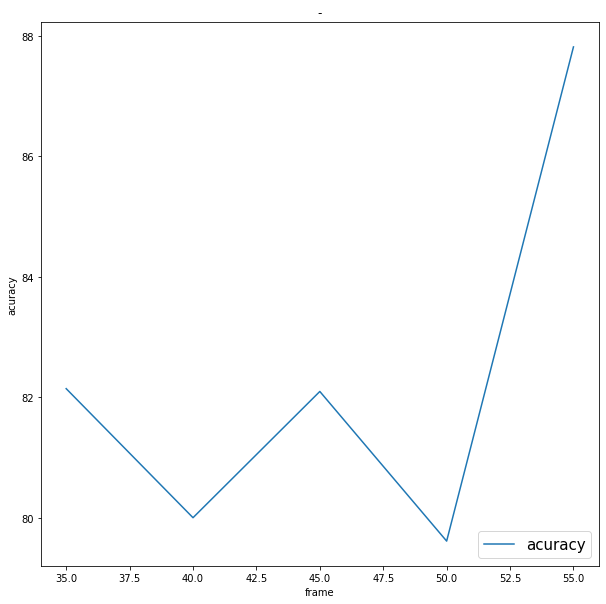

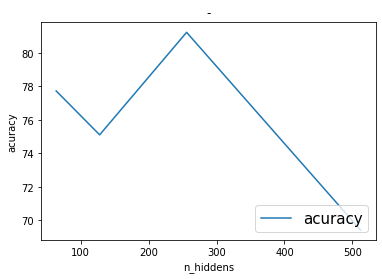

In [45]:
frames = [35, 40, 45, 50, 55]
n_hiddens = [64, 128, 256, 512]
acuracy_frames=list()
acuracy_n_hidden=list()

frame = 45
n_hidden = 128

for i in frames:
    acuracy_frames.append(_train_(i, n_hidden))
    
for i in n_hiddens:
    acuracy_n_hidden.append(_train_(frame, i))
    
    
fig = plt.figure(figsize=(10, 10))

#------------------------------------------------------------------------------
#
plt.plot(frames, acuracy_frames, label='acuracy')

#plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('frame')
plt.ylabel('acuracy')
plt.title('-')
plt.legend(loc="lower right", prop={'size': 15})
plt.show()
#------------------------------------------------------------------------------
#
plt.plot(n_hiddens, acuracy_n_hidden, label='acuracy')

#plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('n_hiddens')
plt.ylabel('acuracy')
plt.title('-')
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

In [ ]:
#При увеличении кол-ва кадров точность росла.
#При увеличении кол-ва модулей лстм точность падает, но видимо надо было уличить кол-во эпох и точность бы даже выросла.